<a href="https://colab.research.google.com/github/davidripsen/DeepLearningProject/blob/master/FC_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pickle5

     |████████████████████████████████| 256 kB 5.3 MB/s 


In [2]:
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import pickle5 as pickle
import torch
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import copy
import scipy.interpolate as interpolate
import random
import datetime
from torch.utils.data import DataLoader, TensorDataset
from google.colab import files

plt.rcParams["figure.figsize"] = (18,9)
RANDOM_SEED = 44
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
seq_len

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
root_path = 'gdrive/My Drive/deep/'  #change dir to your project folder

In [5]:
# Load data
df0 = pickle.load( open( root_path + "data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-0_cleaned.pickle", "rb" ) )
df1 = pickle.load( open( root_path + "data/aligned_GM-7792_DRD-d6b1cf27-41ed-43b6-8050-2068ef941a0aDRD-d6b1cf27-41ed-43b6-8050-2068ef941a0a_GM-7792_pass-1_cleaned.pickle", "rb" ) )

In [6]:
# Merge the two dataframes
df = df0.append(df1, ignore_index=True)
# Shuffle df
df = df.sample(frac=1.0)
df.shape

(3830, 10)

In [ ]:
## Subselect data for dev
#df = df[0:1000]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
!nvidia-smi

Mon Dec  6 09:39:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# up/downsample series

In [9]:
def resample(seq, to_length, window_size):
    '''
    Resample a sequence/
    Parameters
    ----------
    seq : np.array
        Sequence to be resampled.
    to_length : int
        Resample to this number of points.
    Returns
    -------
    d_resampled : np.array
        resampled distance (0,10)
    y_resampled : np.array
        resampled input sequence.
    '''
    # Downsample if needed
    seq_len = seq.shape[0]
    if seq_len>to_length:
        seq = choice(seq, to_length)
        seq_len = seq.shape[0] #
    # Current
    window_size = seq_len #guess if you only want to use first part of TS?
    d = np.linspace(0, window_size, seq_len)
    f = interpolate.interp1d(d, seq)
    # Generate new points
    d_new = np.random.uniform(low=0, high=d[-1], size=(to_length - seq_len))
    # Append new to the initial
    d_resampled = sorted(np.concatenate((d, d_new)))
    # Estimate y at points
    y_resampled = f(d_resampled)
    return d_resampled, y_resampled
    
def resample_df(df, feats_to_resample, to_lengths_dict = {}, window_size = None):
    input_feats_resampled = []
    # Filter rows with less than 2 points (can't resample those)
    for feat in feats_to_resample:
        df[feat+'_len'] =  df[feat].apply(lambda seq: 1 if isinstance(seq, float) else seq.shape[0])
        df.mask(df[feat+'_len']<2, inplace = True)
    # Drop nans (rows with NaN/len<2) and reset index
    df.dropna(subset = feats_to_resample, inplace = True)
    df.reset_index(drop = True, inplace = True)
    # Resample to the maximum
    for feat in feats_to_resample:
        print('Resampling feature: ',feat)
        #max_len = max(df[feat].apply(lambda seq: seq.shape[0]))
        to_length = to_lengths_dict[feat]
        new_feats_resampled = ['{0}_d_resampled'.format(feat), '{0}_resampled'.format(feat)]
        df[new_feats_resampled ] = df.apply(lambda seq: resample(seq[feat], to_length = to_length, window_size = window_size),
                                        axis=1, result_type="expand")
        input_feats_resampled.append('{0}_resampled'.format(feat))
    return df,  input_feats_resampled

In [10]:
def choice(seq, to_length):
  return np.array([seq[i] for i in sorted(random.sample(range(len(seq)), to_length))])

In [11]:
feats_to_resample = ['GM.acc.xyz.z']
to_lengths_dict = {}

for feat in feats_to_resample:
  to_lengths_dict[feat] = int(df[feat].apply(len).quantile(0.83))

In [12]:
resample_df(df, feats_to_resample, to_lengths_dict, None )

Resampling feature:  GM.acc.xyz.z


(     IRI_mean  ...                             GM.acc.xyz.z_resampled
 0     2.84119  ...  [0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.996...
 1     4.37139  ...  [0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.996...
 2     6.82202  ...  [0.9883, 0.9883, 0.9883, 0.9883, 0.9883, 0.988...
 3     3.49319  ...  [1.043, 1.043, 1.054037632555458, 1.1402756141...
 4     2.58393  ...  [0.9375, 0.9375, 0.9375, 0.9375, 0.9336, 0.933...
 ...       ...  ...                                                ...
 3825  1.33265  ...  [1.0117, 1.0117, 1.0117, 1.0117, 1.0547, 1.054...
 3826  4.38201  ...  [1.0078, 1.0078, 1.0078, 1.0078, 1.0078, 1.007...
 3827  2.51601  ...  [1.0781, 1.0781, 1.0781, 1.0781, 1.0781, 1.078...
 3828  6.13532  ...  [0.9844, 0.9844, 1.0039, 1.0039, 1.0039, 1.003...
 3829  2.43493  ...  [0.9727, 0.9453, 0.9688, 0.9688, 0.9688, 0.960...
 
 [3830 rows x 13 columns], ['GM.acc.xyz.z_resampled'])

### Threshold data on IRI_mean > 5  <=> outlier

In [13]:
iri_threshold = 5
normal_df = df['GM.acc.xyz.z_resampled'][df['IRI_mean'] <= iri_threshold]
normal_df = pd.DataFrame(normal_df.tolist())
normal_df.shape

(3410, 3996)

In [14]:
df['IRI_anomaly'] = df['IRI_mean'] >= iri_threshold

In [15]:
anomaly_df = df['GM.acc.xyz.z_resampled'][df['IRI_mean'] >= iri_threshold]
anomaly_df = pd.DataFrame(anomaly_df.tolist())
anomaly_df.shape

(420, 3996)

In [16]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

# convert to tensors

In [17]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [18]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

## DataLoader

In [19]:
batch_size = 128 #crashes at larger than 100 with 1 hidden layer

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [20]:
x = next(iter(train_dataloader))
x.reshape([batch_size,seq_len]).shape

torch.Size([128, 3996])

# Define Model

In [21]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features=1, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, int(2 * embedding_dim/20)

        #self.rnn1 = nn.LSTM(          #(Batch Size, Sequence Length, Hidden Units)
        #  input_size=n_features,
        #  hidden_size=self.hidden_dim,
        #  num_layers=1,
        #  batch_first=True,
        #)

        #self.rnn2 = nn.LSTM(
        #  input_size=self.hidden_dim,
        #  hidden_size=int(self.hidden_dim/2),
        #  num_layers=1,
        #  batch_first=True
        #)

        #linear layer, one linear layer with units.
        self.output_layer = nn.Linear(in_features = seq_len, out_features = embedding_dim, bias=True)

    def forward(self, x, batch_size):
        #x = x.reshape((batch_size, self.seq_len, self.n_features))
        #print('førstelag1', x.shape)
        #x, (_, _) = self.rnn1(x)
        #print('førstelag2', x.shape)
        #x, (_, _) = self.rnn2(x) #output

        #x = x[:,-1,:]# (batch_size, 1, embedding_dim) fastest?
        
        x = x.reshape([batch_size, self.seq_len])
        x = self.output_layer(x)

        #x = x.unsqueeze(1)

        #print(x.shape)
        
        #print('b', x.shape)
        #print('c',hidden_n.shape)
        
        return x

In [22]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = int(2 * input_dim/20), n_features

        
        #self.rnn1 = nn.LSTM(    
        #  input_size=self.input_dim, #10 features from latent space
        #  hidden_size=1,
        #  num_layers=1,
        #  batch_first=True
        #)

        #self.rnn2 = nn.LSTM(
        #  input_size=self.hidden_dim,
        #  hidden_size= 1, #self.hidden_dim, #hidden dim 1
        #  num_layers=1,
        #  batch_first=True
        #)

        self.output_layer = nn.Linear(in_features = self.input_dim, out_features = seq_len, bias=True) # out_features = n_features #delete this layer

    def forward(self, x, batch_size):
        #print('0', x.shape)
        #x = x.repeat(1, self.seq_len, self.n_features) #batchsize, sequence length, latent
        #print('1', x.shape)
        #x = x.reshape((batch_size, self.seq_len, self.input_dim))
        #print('2', x.shape)
        
        #x, (hidden_n, cell_n) = self.rnn1(x)
        #print('3', x.shape)
        #x, (hidden_n, cell_n) = self.rnn2(x)
        #print('4', x.shape)
        
        #x = x.reshape((batch_size, self.seq_len, self.hidden_dim))
        #print('5', x.shape)
        #print(x.shape)
        x = self.output_layer(x)
        x = x = x.reshape([batch_size, self.seq_len,1])
        return x #self.output_layer(x)

In [23]:
class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x, batch_size):
        
        x = self.encoder(x, batch_size)
        x = self.decoder(x, batch_size)

        return x

# Training loop

In [24]:
def train_model(model, train_dataloader, val_dataloader, n_epochs, batch_size):
    optimizer =  torch.optim.AdamW(model.parameters(), lr=1e-4)    # Crashes with: torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) 
    criterion = nn.MSELoss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_loss = 10000.0
    best_model_wts = copy.deepcopy(model.state_dict())   # Save model
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        #for seq_true in train_dataset:
        for i, X in enumerate(train_dataloader):
            #if i % 5 == 0:
            #  print('Batch iteration:', i)
            seq_true = X.to(device)
            seq_pred = model(seq_true, batch_size)

            loss = criterion(seq_pred, seq_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
     
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for X in val_dataloader:
                seq_true = X.to(device)
                seq_pred = model(seq_true, batch_size)
            
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        #print(train_losses)    
        train_loss = np.mean(train_losses)

        #print(val_losses)    
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict()) # save model

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

# Clear cuda cache

In [ ]:
# Clear memory
try:
  del model
except:
  print("No model initiated")

torch.cuda.empty_cache()
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

# Instantiate model

In [27]:
# Choose number of latent variables
embedding_dim = seq_len

model = RecurrentAutoencoder(seq_len, n_features, embedding_dim=embedding_dim)
model = model.to(device)
model.eval()

RecurrentAutoencoder(
  (encoder): Encoder(
    (output_layer): Linear(in_features=3996, out_features=3996, bias=True)
  )
  (decoder): Decoder(
    (output_layer): Linear(in_features=3996, out_features=3996, bias=True)
  )
)

# Train model

In [ ]:
search = True # Grid search?
variableregion = [5, 10, 100, 1000, seq_len] # Grid

In [ ]:
if search:
  # Grid search
  histories = list()
  for embedding_dim in variableregion:
    # Def. model
    model = RecurrentAutoencoder(seq_len, n_features, embedding_dim=embedding_dim)
    model = model.to(device)

    print(datetime.datetime.now())
    model, history = train_model(
      model,
      train_dataloader, 
      val_dataloader, 
      n_epochs=500,
      batch_size = batch_size
    )
    histories.append( history['val'] )
    print(datetime.datetime.now())

else: # Fit specified single model 
    print(datetime.datetime.now())
    model, history = train_model(
      model,
      train_dataloader, 
      val_dataloader, 
      n_epochs=1000,
      batch_size = batch_size
    )
    print(datetime.datetime.now())




2021-12-03 12:05:23.535646
Epoch 1: train loss 552278.65625 val loss 543809.15625
Epoch 2: train loss 540224.6335227273 val loss 538447.21875
Epoch 3: train loss 537027.5426136364 val loss 536257.5625
Epoch 4: train loss 534439.875 val loss 533458.21875
Epoch 5: train loss 531699.3323863636 val loss 530553.0
Epoch 6: train loss 528624.3352272727 val loss 527152.65625
Epoch 7: train loss 525186.140625 val loss 523631.78125
Epoch 8: train loss 521082.84375 val loss 519036.171875
Epoch 9: train loss 516156.890625 val loss 513629.21875
Epoch 10: train loss 510328.5724431818 val loss 507240.828125
Epoch 11: train loss 503539.92329545453 val loss 500101.46875
Epoch 12: train loss 495813.3934659091 val loss 491690.59375
Epoch 13: train loss 487165.19176136365 val loss 482769.046875
Epoch 14: train loss 477746.83238636365 val loss 472841.71875
Epoch 15: train loss 467657.15482954547 val loss 462337.640625
Epoch 16: train loss 457005.1946022727 val loss 451528.8125
Epoch 17: train loss 446002.7

# Loss plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

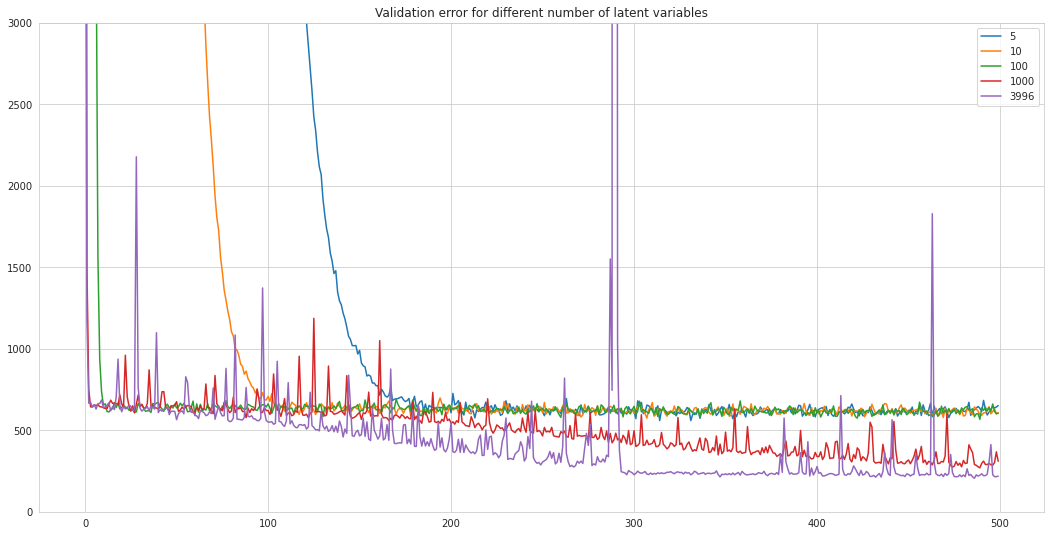

In [ ]:
if search:
  for i, emb in enumerate(variableregion):
    plt.ylim([0,3000])
    plt.plot(histories[i], label=str(emb))
  plt.title("Validation error for different number of latent variables")
  plt.legend()
  plt.savefig('Grid1.eps', format='eps')
  files.download("Grid.png") 

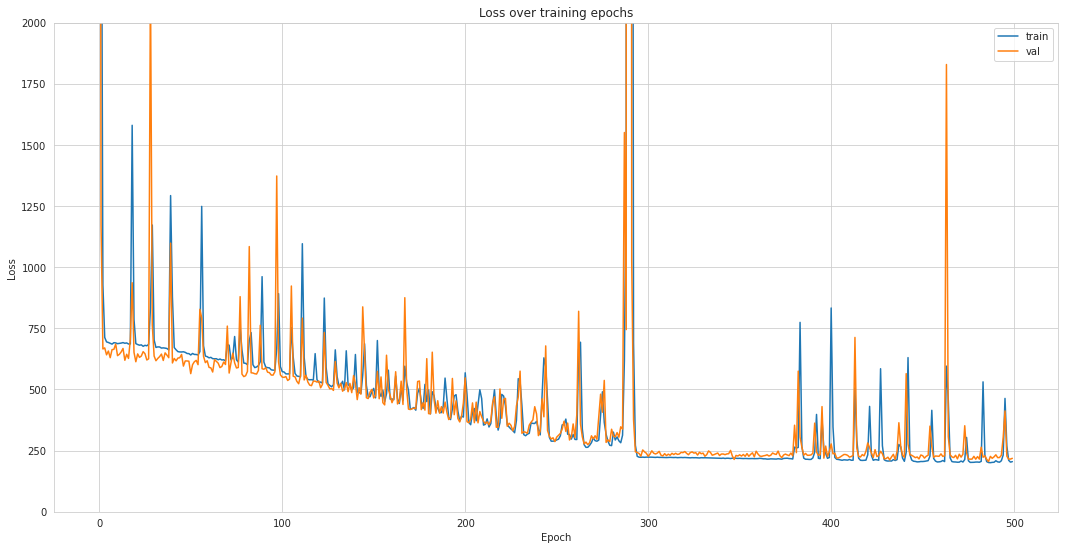

In [ ]:
ax = plt.figure().gca()
ax.set_ylim([0,2000])

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show();

#Save model

In [ ]:
MODEL_PATH = 'model-03-12.pth'
torch.save(model.state_dict(), root_path+MODEL_PATH)

# Load model

In [28]:
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim)
model = model.to(device)
model.load_state_dict(torch.load(root_path + 'model-03-12.pth'))
model.eval()

RecurrentAutoencoder(
  (encoder): Encoder(
    (output_layer): Linear(in_features=3996, out_features=3996, bias=True)
  )
  (decoder): Decoder(
    (output_layer): Linear(in_features=3996, out_features=3996, bias=True)
  )
)

# Prediction plots

In [29]:
def predict(model, dataset, batch_size):
  predictions, losses = [], []
  criterion = nn.MSELoss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = torch.unsqueeze(seq_true,0)
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true, batch_size) # Predict/Reconstruct

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [30]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data], batch_size=1)

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

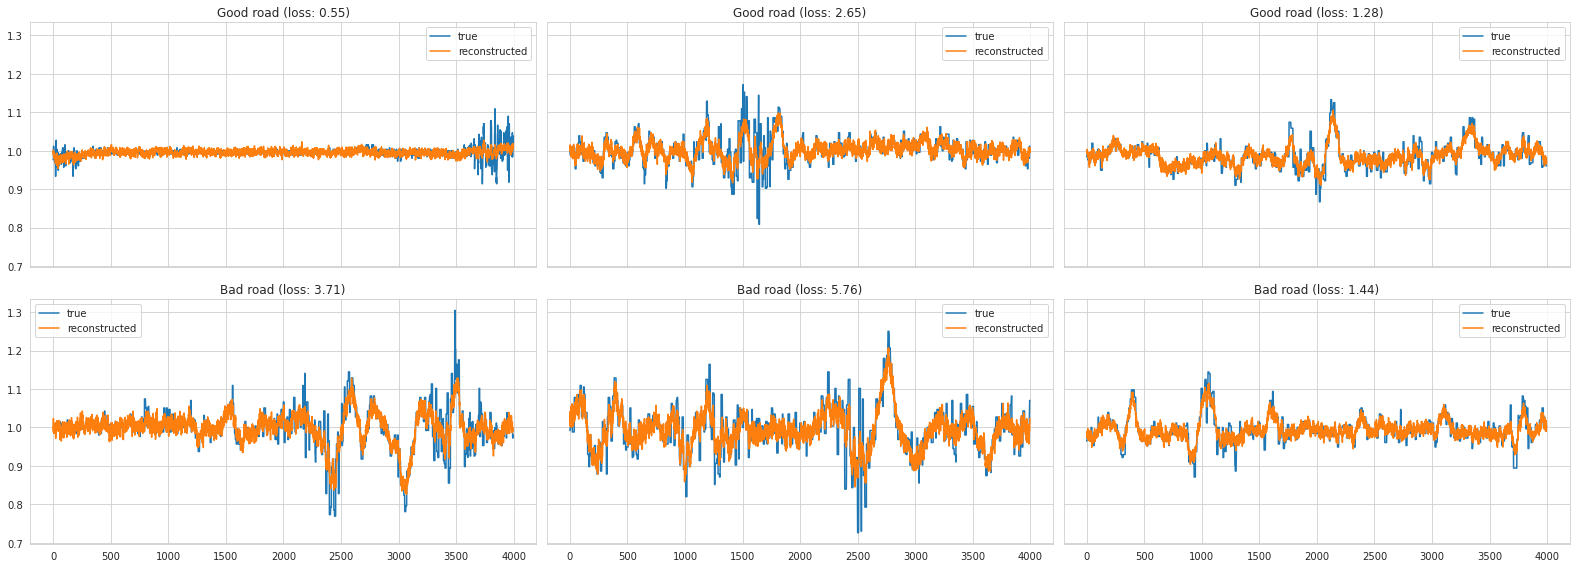

In [32]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=3, # usually: 6
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)


for i, data in enumerate(test_normal_dataset[:3]): # usually: plot 6
  plot_prediction(data, model, title='Good road', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:3]):
  plot_prediction(data, model, title='Bad road', ax=axs[1, i])

fig.tight_layout();
plt.savefig('FC-reconstructions.eps', format='eps')
files.download("FC-reconstructions.eps") 

# Asses reconstruction
on normal and non-normal data from test set - and decide on a good threshold of reconstruction error to predict normal/anomaly.

Use .../... curves to identify best threshold.


In [ ]:
# Load trained model
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim=seq_len)
model = model.to(device)
model.load_state_dict(torch.load(root_path + 'model-03-12.pth'))
model.eval()

RecurrentAutoencoder(
  (encoder): Encoder(
    (output_layer): Linear(in_features=3996, out_features=3996, bias=True)
  )
  (decoder): Decoder(
    (output_layer): Linear(in_features=3996, out_features=3996, bias=True)
  )
)

In [ ]:
normal_preds, normal_losses = predict(model, test_normal_dataset, batch_size=1)
anomaly_preds, anomaly_losses = predict(model, test_anomaly_dataset, batch_size=1)
#
print('Size of test_normal dataset:', len(normal_losses), "  Size of test_anomaly dataset: ", len(anomaly_losses))

Size of test_normal dataset: 169   Size of test_anomaly dataset:  420


## Reconstruction plot: Good vs Bad

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

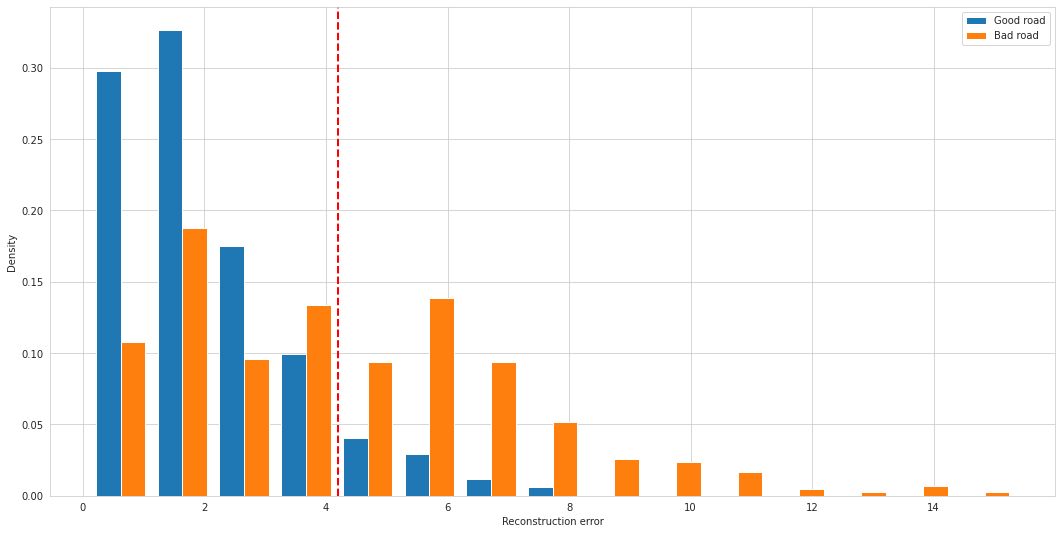

In [ ]:
plt.hist([normal_losses, anomaly_losses], density=True, bins=15);
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.legend(["Good road", "Bad road"])

# From the below plot, choose a threshold and add it to the plot
chosen_thresh = 4.2
plt.axvline(x=chosen_thresh, color='r', linestyle='dashed', linewidth=2)
plt.savefig('FC2.eps', format='eps')
files.download("FC2.eps") 

We clearly see that the reconstruction error is much higher for anomalies. An imediate threshold for discrimination between the two classes seems to be: **4.2**

Instead of using Precision-Recall (which isn't really fit in this case, since the number of anomalies is much great than the number of normals in the test set) - we will use ROC-curves.

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, roc_auc_score

## Precision-Recall and ROC

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

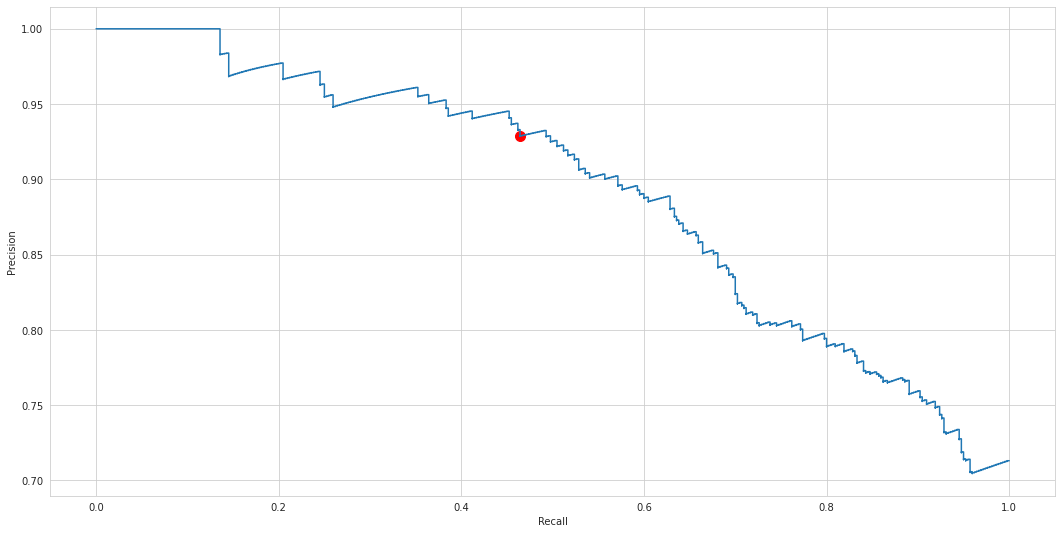

In [ ]:
chosen_thresh = 4.2

#
preds_all = np.concatenate([normal_losses, anomaly_losses])
true_all = np.concatenate([np.zeros(len(normal_losses)), np.ones(len(anomaly_losses))])

# Precision-Recall curve
# Precision = proportion of correct anomaly-predictionsb
# Recall = proportion of correctly classified anomalies (!)
precision, recall, threshold = precision_recall_curve(true_all, preds_all)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

idx = np.where(threshold > chosen_thresh)[0][0]
plt.scatter(recall[idx],precision[idx], c="red", s=100)
plt.savefig('FC-ROC.eps', format='eps')
files.download("FC-ROC.eps") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

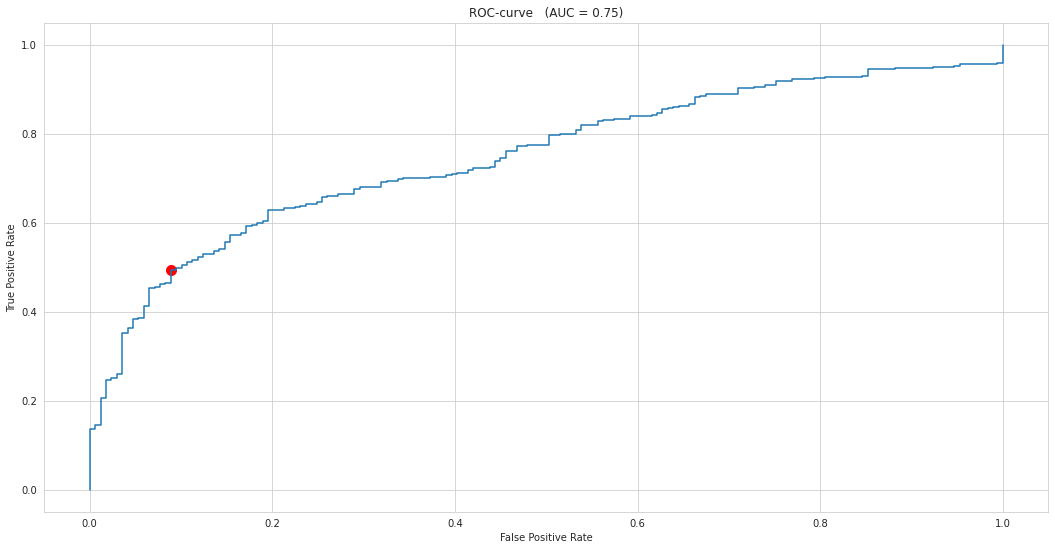

In [ ]:
# ROC-curve
fpr_roc, tpr_roc, threshold_roc = roc_curve(true_all, preds_all)

RocCurveDisplay(fpr=fpr_roc, tpr=tpr_roc).plot()
idx = np.where(threshold_roc < chosen_thresh)[0][0]
plt.scatter(fpr_roc[idx],tpr_roc[idx], c="red", s=100)
plt.title(f'ROC-curve   (AUC = {roc_auc_score(true_all, preds_all).round(2)})');

plt.savefig('FC-ROC2.eps', format='eps')
files.download("FC-ROC2.eps") 

# MEAN MODEL

In [ ]:
def mean_predict(data):
  means = list()
  reconstructions = list()
  losses = list()

  for i, obs in enumerate(data):
    means.append( obs.mean() )
    reconstructions.append( means[i].repeat(seq_len) )
    losses.append( (obs.transpose(0,1) - reconstructions[i]).square().sum() )

  return reconstructions, losses, means

In [ ]:
normal_meanrecon, normal_meanlosses, normal_means = mean_predict(test_normal_dataset)
anomaly_mean_recon, anomaly_meanlosses, anomaly_means = mean_predict(test_anomaly_dataset)

## Reconstruction of observations

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

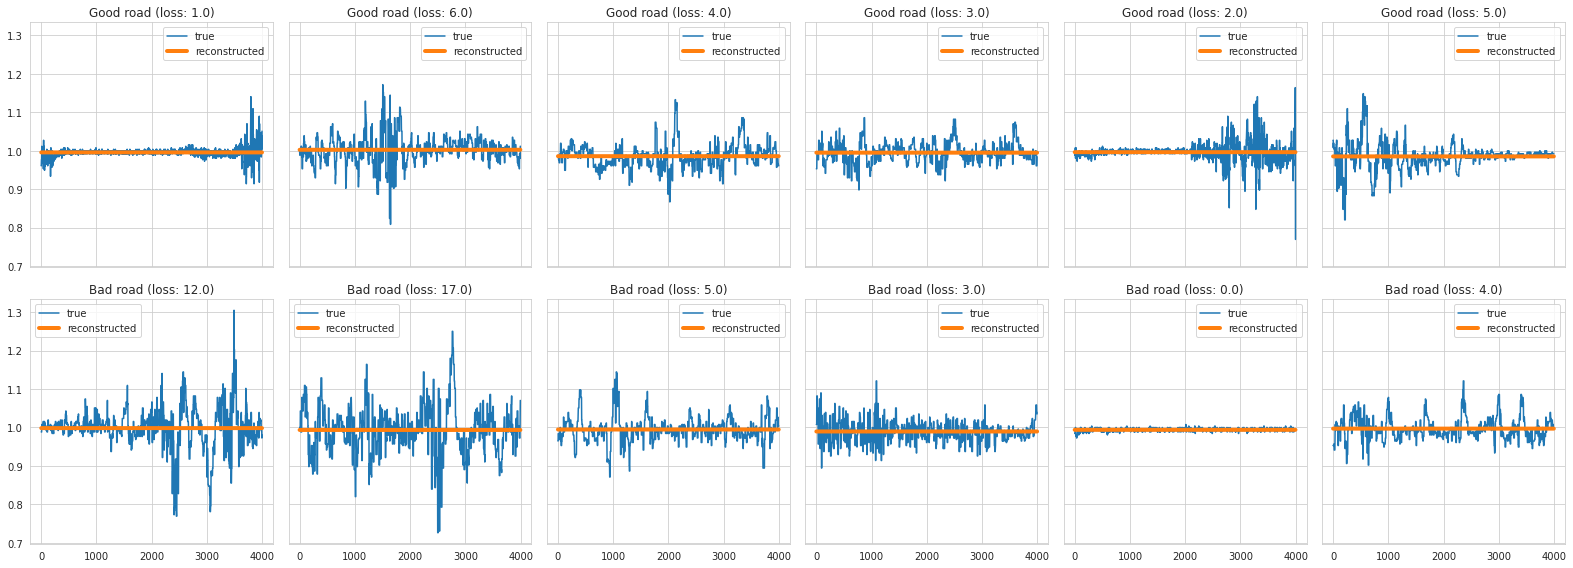

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)


for i in range(6):
  predictions = normal_meanrecon[i]
  pred_losses = normal_meanlosses[i]
  title = 'Good road'
  ax=axs[0, i]

  ax.plot(test_normal_dataset[i], label='true')
  ax.plot(predictions, label='reconstructed', linewidth=4)
  ax.set_title(f'{title} (loss: {pred_losses.round()})')
  ax.legend()

for i in range(6):
  predictions = anomaly_mean_recon[i]
  pred_losses = anomaly_meanlosses[i]
  title = 'Bad road'
  ax=axs[1, i]
  
  ax.plot(test_anomaly_dataset[i], label='true')
  ax.plot(predictions, label='reconstructed', linewidth=4)
  ax.set_title(f'{title} (loss: {pred_losses.round()})')
  ax.legend()

fig.tight_layout();
plt.savefig('Mean-recon.eps', format='eps')
files.download("Mean-recon.eps") 

## Reconstruction plot: Good vs Bad

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

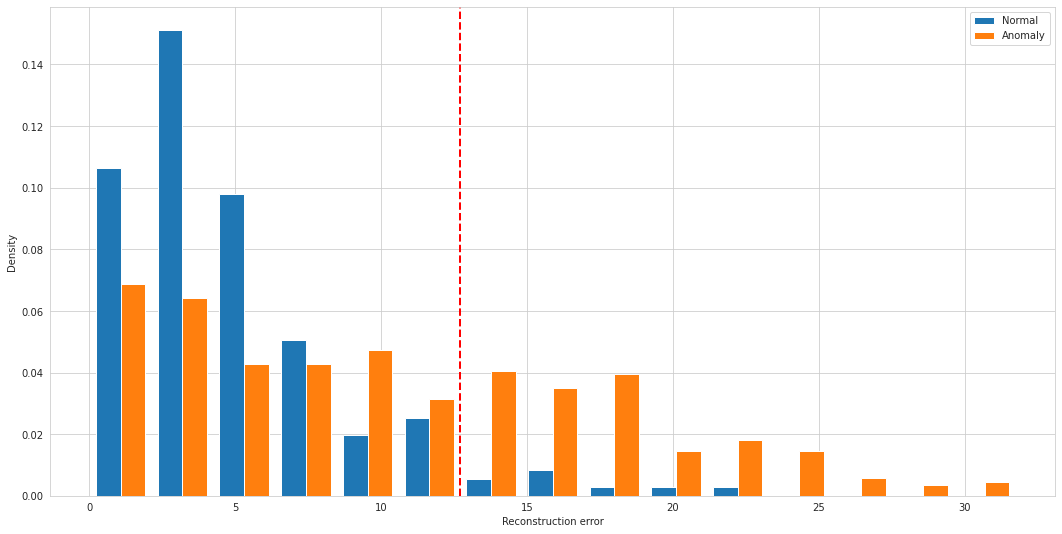

In [ ]:
plt.hist([normal_meanlosses, anomaly_meanlosses], density=True, bins=15);
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.legend(["Normal", "Anomaly"])

# From the below plot, choose a threshold and add it to the plot
chosen_thresh2 = 12.7
plt.axvline(x=chosen_thresh2, color='r', linestyle='dashed', linewidth=2)
plt.savefig('Mean1.eps', format='eps')
files.download("Mean1.eps") 

## Precision-Recall and ROC

In [ ]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, roc_auc_score

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

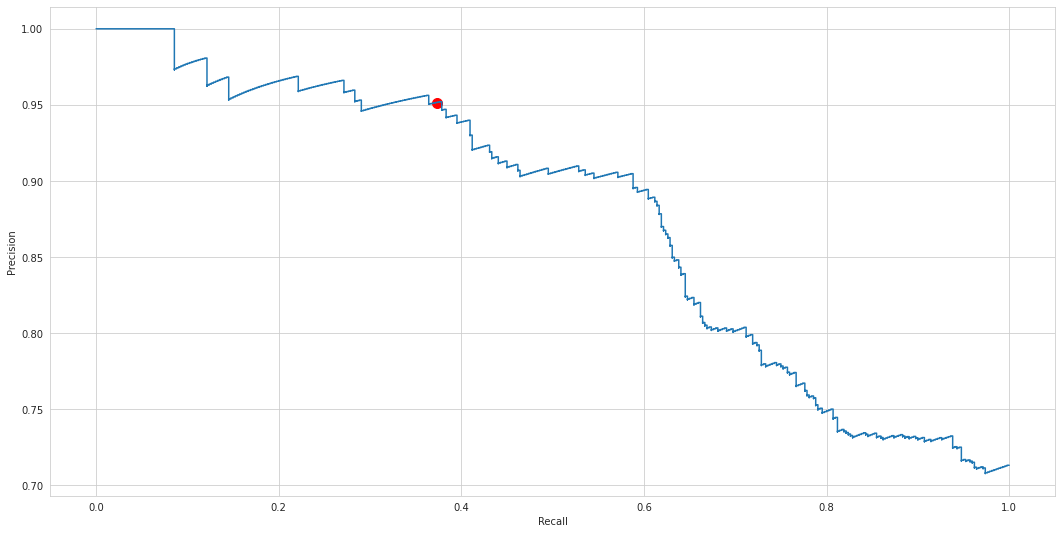

In [ ]:
preds_all2 = np.concatenate([normal_meanlosses, anomaly_meanlosses])
true_all2 = np.concatenate([np.zeros(len(normal_losses)), np.ones(len(anomaly_losses))])

# Precision-Recall curve
# Precision = proportion of correct anomaly-predictionsb
# Recall = proportion of correctly classified anomalies (!)
precision, recall, threshold = precision_recall_curve(true_all2, preds_all2)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

idx = np.where(threshold > chosen_thresh2)[0][0]
plt.scatter(recall[idx],precision[idx], c="red", s=100)
plt.savefig('Mean-ROC1.eps', format='eps')
files.download("Mean-ROC1.eps") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

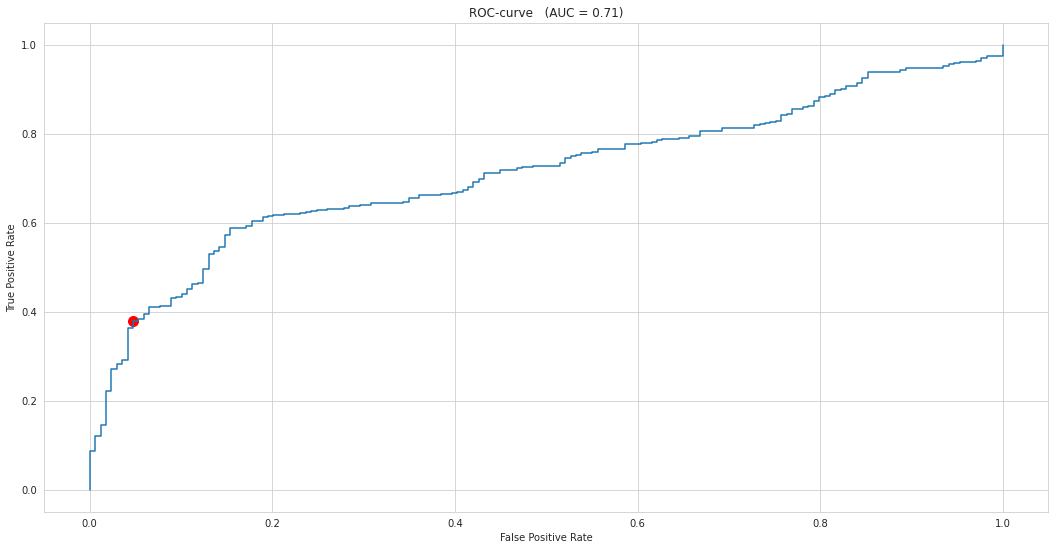

In [ ]:
# ROC-curve
fpr_roc, tpr_roc, threshold_roc = roc_curve(true_all2, preds_all2)

RocCurveDisplay(fpr=fpr_roc, tpr=tpr_roc).plot()
idx = np.where(threshold_roc < chosen_thresh2)[0][0]
plt.scatter(fpr_roc[idx],tpr_roc[idx], c="red", s=100)
plt.title("ROC-curve - AUC = ")
plt.title(f'ROC-curve   (AUC = {roc_auc_score(true_all2, preds_all2).round(2)})');
plt.savefig('Mean-ROC2.eps', format='eps')
files.download("Mean-ROC2.eps") 

In [ ]:
roc_auc_score(true_all, preds_all)

0.7115243730628347